<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/phophet_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Load the dataset (adjust the file path in Colab as needed)
file_path = '/content/Ladders updated data.xlsx'
data = pd.ExcelFile(file_path)

# Load the 'Data' sheet
df = data.parse('Data')

# Display the first few rows to understand the structure
print(df.head())

  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  


In [4]:
# Convert 'Billing Date' to datetime
df['Billing Date'] = pd.to_datetime(df['Billing Date'])

# Remove commas and convert 'Invoice Value' to numeric
df['Invoice Value'] = df['Invoice Value'].replace({',': ''}, regex=True).astype(float)


In [5]:
# Rename 'QTY(EA)' to 'Quantity'
df.rename(columns={'QTY(EA)': 'Quantity'}, inplace=True)

# Handle negative values (optional: filter out returns/cancellations)
df = df[(df['Quantity'] > 0) & (df['Invoice Value'] > 0)]

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Billing Date     0
Net Weight       0
Sales Region     0
Invoice Value    0
Material Code    0
Size             0
Quantity         0
dtype: int64


In [6]:
# Remove duplicates
df = df.drop_duplicates()

print("\nCleaned Dataset:")
print(df)


Cleaned Dataset:
     Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0      2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1      2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2      2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3      2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4      2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   
...           ...         ...          ...            ...                ...   
7647   2024-10-29   31.040000           R3       79022.08  FAML0304N000N1200   
7648   2024-10-29   40.785000           R3       91962.00  FAML0404N000N1600   
7649   2024-10-29   63.000000           R3       13274.60  FASL3000M000L0400   
7650   2024-10-29  105.000000           R3       27722.61  FASL3000M000L0500   
7651   2024-10-29  105.000000           R3       33187.83  FASL3000M000L0600   

                     

In [7]:
region_data = {
    'Sales Region': ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'PR', 'PR-EX', 'EX', 'DR'],
    'Region Name': ['North', 'Kandy', 'Kurunagela', 'Southern', 'Negombo', 'East', 'Colombo', 'Key accounts', 'Projects', 'Projects Export', 'Exports', 'Direct']
}
region_df = pd.DataFrame(region_data)
df = df.merge(region_df, on='Sales Region', how='left')

# Create 'Is_Export' feature
df['Is_Export'] = df['Sales Region'].apply(lambda x: 1 if x in ['EX', 'PR-EX'] else 0)


In [8]:
# Create 'Product Category' feature
df['Product Category'] = df['Material Code'] + ' - ' + df['Size']

# Create 'Price per Unit' feature
df['Price per Unit'] = df['Invoice Value'] / df['Quantity']

In [9]:
# Extract time-based features
df['Year'] = df['Billing Date'].dt.year
df['Month'] = df['Billing Date'].dt.month
df['Day'] = df['Billing Date'].dt.day
df['Day of Week'] = df['Billing Date'].dt.dayofweek

In [10]:
# Create 'Season' feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

print("\nDataset after Feature Engineering:")
print(df.head())


Dataset after Feature Engineering:
  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  Quantity Region Name  Is_Export  \
0  Multy Purpose Ladder         1     Exports          1   
1           STEP LADDER         1       Kandy          0   
2           STEP LADDER         1       Kandy          0   
3           STEP LADDER         1       Kandy          0   
4           STEP LADDER         1       Kandy          0   

                           Product Category  Price per Unit  Year  Month  Day  \
0  FAML0504N000N2000 - Multy Purpose Ladder           71.50

In [11]:
# Select features and target
X = df[['Net Weight', 'Invoice Value', 'Quantity', 'Year', 'Month', 'Day', 'Day of Week', 'Is_Export', 'Price per Unit']]
y = df['Quantity']

In [12]:
# Encode categorical features
categorical_features = ['Region Name', 'Product Category', 'Season']
X_categorical = df[categorical_features]

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X_categorical)
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

<ipython-input-13-5f30566ec908>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Billing Date', y='Quantity', data=df, estimator='sum', ci=None)


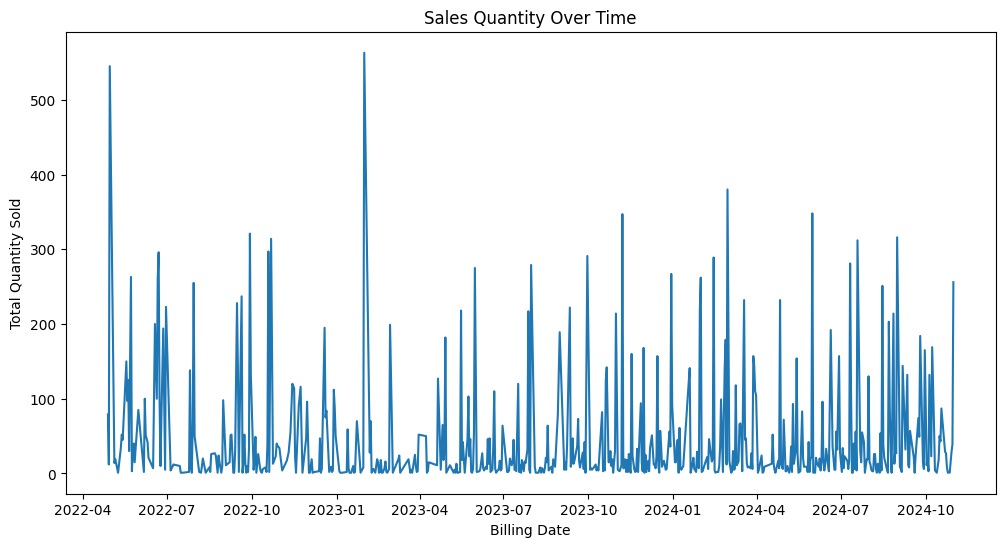

In [13]:
# Visualization 1: Sales Trends Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Billing Date', y='Quantity', data=df, estimator='sum', ci=None)
plt.title('Sales Quantity Over Time')
plt.xlabel('Billing Date')
plt.ylabel('Total Quantity Sold')
plt.show()


<ipython-input-14-283770a22eef>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Region Name', y='Quantity', data=df, estimator=sum, ci=None)


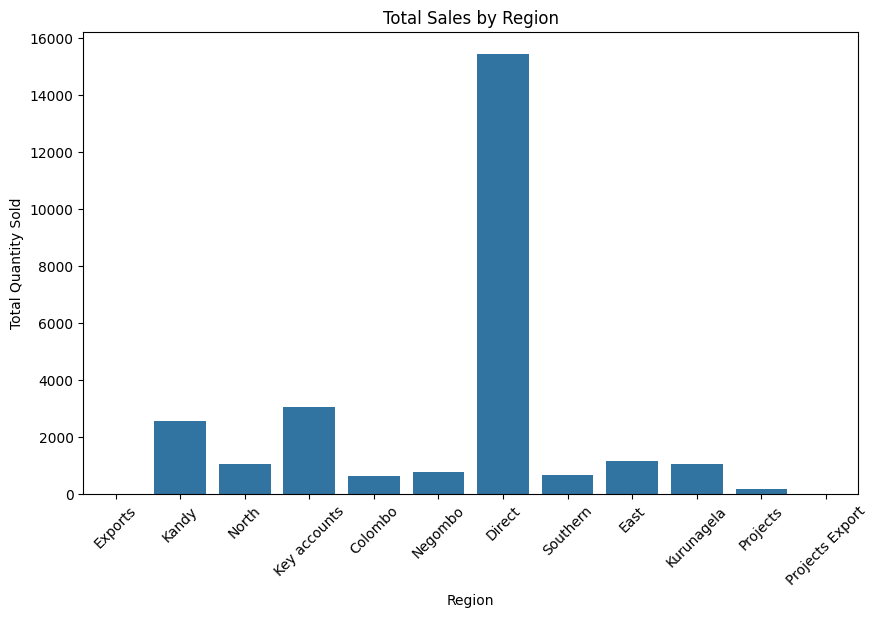

In [14]:
# Visualization 2: Sales by Region
plt.figure(figsize=(10, 6))
sns.barplot(x='Region Name', y='Quantity', data=df, estimator=sum, ci=None)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-65d7a82e7926>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Product Category', y='Quantity', data=df, estimator=sum, ci=None)


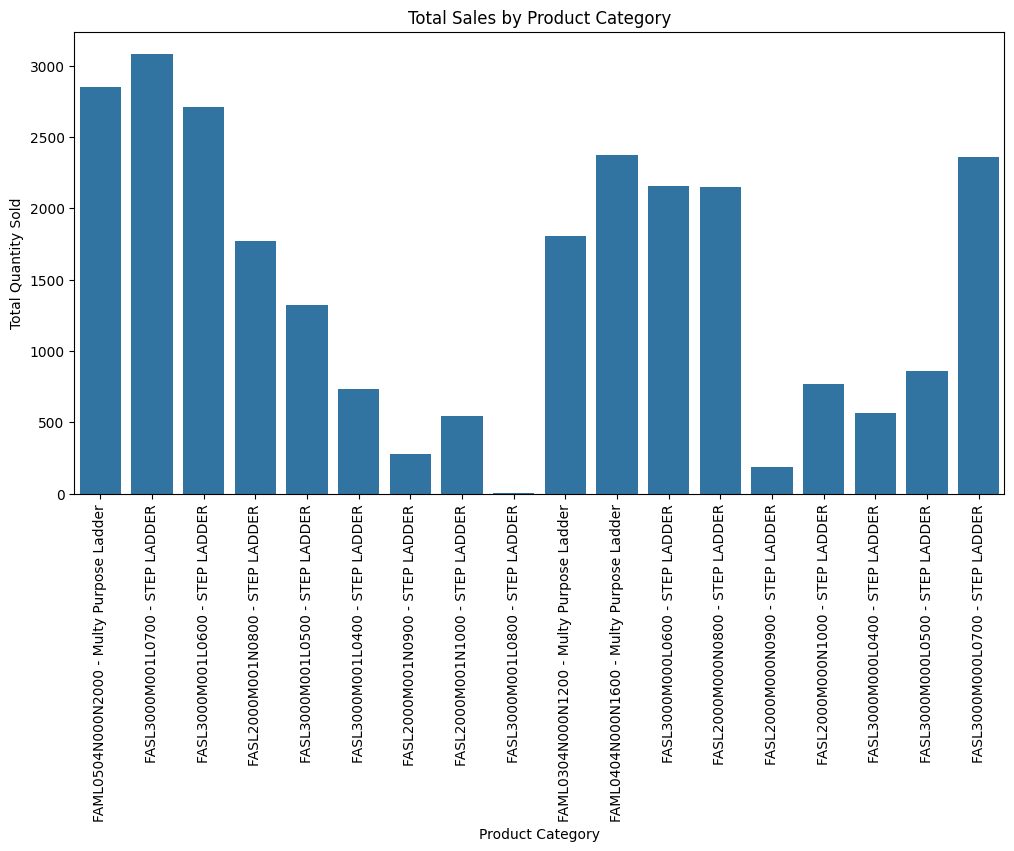

In [15]:
# Visualization 3: Sales by Product Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Product Category', y='Quantity', data=df, estimator=sum, ci=None)
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.show()

<ipython-input-16-56984d304b56>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Quantity'].resample('M').sum()


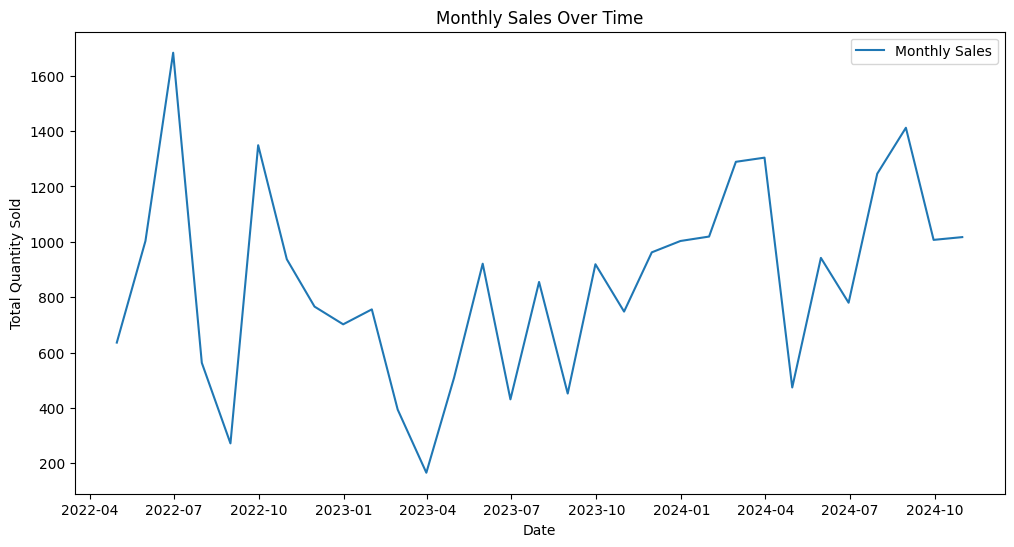

In [16]:

# Convert 'Billing Date' to datetime and set it as the index
df['Billing Date'] = pd.to_datetime(df['Billing Date'])
df.set_index('Billing Date', inplace=True)

# Aggregate sales data by month
monthly_sales = df['Quantity'].resample('M').sum()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()

In [18]:
# Aggregate sales data by day
daily_sales = df.groupby('Billing Date')['Quantity'].sum().reset_index()

# Rename columns for Prophet
daily_sales.rename(columns={'Billing Date': 'ds', 'Quantity': 'y'}, inplace=True)

print("Prepared Data for Prophet:")
print(daily_sales.head())
print(daily_sales.tail())

Prepared Data for Prophet:
          ds    y
0 2022-04-28   79
1 2022-04-29   12
2 2022-04-30  545
3 2022-05-05   14
4 2022-05-06   19
            ds    y
605 2024-10-26    2
606 2024-10-27    1
607 2024-10-29   29
608 2024-10-30   39
609 2024-10-31  256


In [20]:
# Split the data into training and testing sets
train_size = int(len(daily_sales) * 0.8)
train = daily_sales[:train_size]
test = daily_sales[train_size:]

print(f"Training data: {len(train)} rows")
print(f"Testing data: {len(test)} rows")

Training data: 488 rows
Testing data: 122 rows


In [21]:
from prophet import Prophet

# Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/_3wn1rk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/cago4yv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65187', 'data', 'file=/tmp/tmpajlnc4yv/_3wn1rk2.json', 'init=/tmp/tmpajlnc4yv/cago4yv0.json', 'output', 'file=/tmp/tmpajlnc4yv/prophet_modeln_2sg9rp/prophet_model-20250205193617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
# Create a future dataframe for the test period
future = model.make_future_dataframe(periods=len(test))

# Make predictions
forecast = model.predict(future)

# Extract predictions for the test period
predictions = forecast[['ds', 'yhat']].tail(len(test))

# Merge predictions with actual values
results = pd.merge(test, predictions, on='ds', how='inner')

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

# Calculate MAE
mae = mean_absolute_error(results['y'], results['yhat'])

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(results['y'], results['yhat'])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 83.27871370748747
MAE: 46.890355525513
MAPE: 466.93513849490296%


In [24]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [25]:
from itertools import product

# Initialize variables to store the best results
best_params = None
best_rmse = float('inf')

# Perform grid search
for params in product(*param_grid.values()):
    changepoint_prior_scale, seasonality_prior_scale, seasonality_mode = params

    # Initialize and fit the Prophet model
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model.fit(train)

    # Make predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    predictions = forecast[['ds', 'yhat']].tail(len(test))

    # Calculate RMSE
    results = pd.merge(test, predictions, on='ds', how='inner')
    rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

    # Update the best parameters if the current RMSE is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'changepoint_prior_scale': changepoint_prior_scale,
            'seasonality_prior_scale': seasonality_prior_scale,
            'seasonality_mode': seasonality_mode
        }

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/46hf7ytj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/akjdp97g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9752', 'data', 'file=/tmp/tmpajlnc4yv/46hf7ytj.json', 'init=/tmp/tmpajlnc4yv/akjdp97g.json', 'output', 'file=/tmp/tmpajlnc4yv/prophet_modelw9bupd53/prophet_model-20250205193653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/wmmi3rcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/_7xnw7ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Best RMSE: 75.90567636485235


In [26]:
# Train the final model with the best parameters
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
final_model.fit(daily_sales)

# Save the final model
import joblib
final_model_filename = 'final_prophet_model.pkl'
joblib.dump(final_model, final_model_filename)

print(f"Final Prophet model saved to {final_model_filename}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/0dvv5utw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajlnc4yv/9gry3wq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43253', 'data', 'file=/tmp/tmpajlnc4yv/0dvv5utw.json', 'init=/tmp/tmpajlnc4yv/9gry3wq5.json', 'output', 'file=/tmp/tmpajlnc4yv/prophet_modeldebdn709/prophet_model-20250205193706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Final Prophet model saved to final_prophet_model.pkl


In [38]:
# Make predictions with the final model
# Ensure future dataframe aligns with the test data's date range
future = final_model.make_future_dataframe(periods=len(test), freq='D')  # Specify daily frequency
forecast = final_model.predict(future)

# Instead of filtering, select the required columns and then filter by date
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # Include 'yhat_lower' and 'yhat_upper'
predictions = predictions[predictions['ds'].isin(test['ds'])]  # Filter by date

# Calculate evaluation metrics
results = pd.merge(test, predictions, on='ds', how='inner')
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
mae = mean_absolute_error(results['y'], results['yhat'])
mape = mean_absolute_percentage_error(results['y'], results['yhat'])

print(f"Final Model RMSE: {rmse}")
print(f"Final Model MAE: {mae}")
print(f"Final Model MAPE: {mape}%")

Final Model RMSE: 73.23057658065551
Final Model MAE: 49.151208854496744
Final Model MAPE: 815.8601964611134%


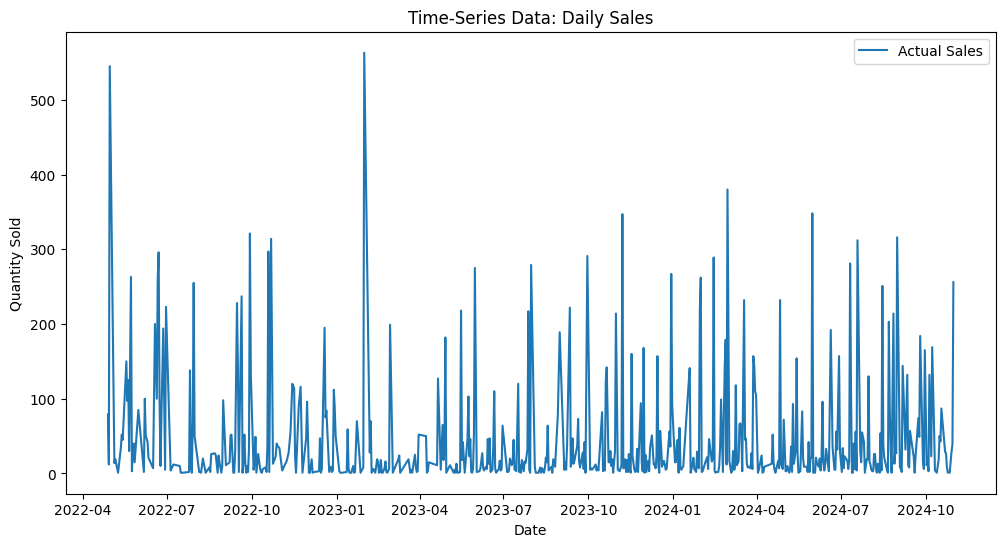

In [29]:

# Plot the time-series data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'], label='Actual Sales')
plt.title('Time-Series Data: Daily Sales')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

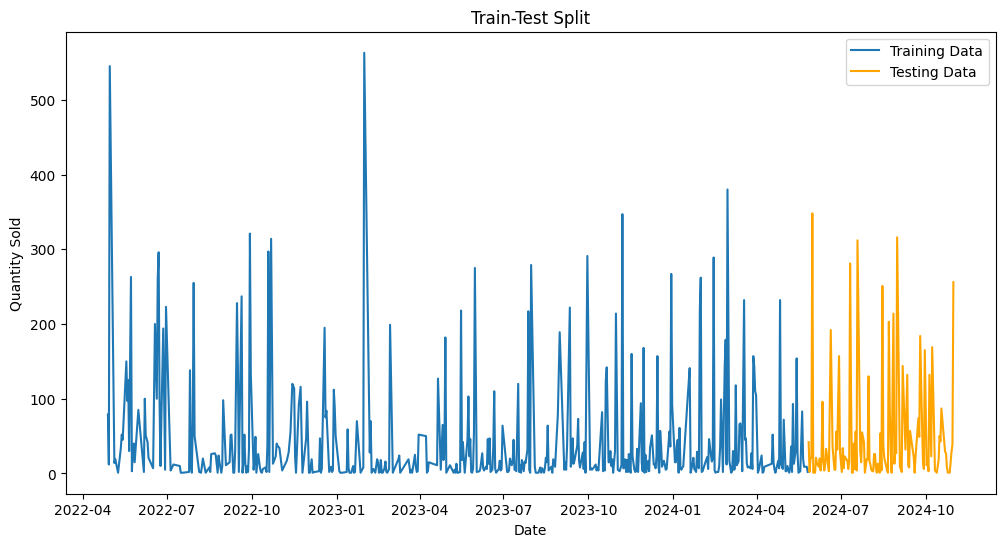

In [30]:
# Plot the train-test split
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Testing Data', color='orange')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

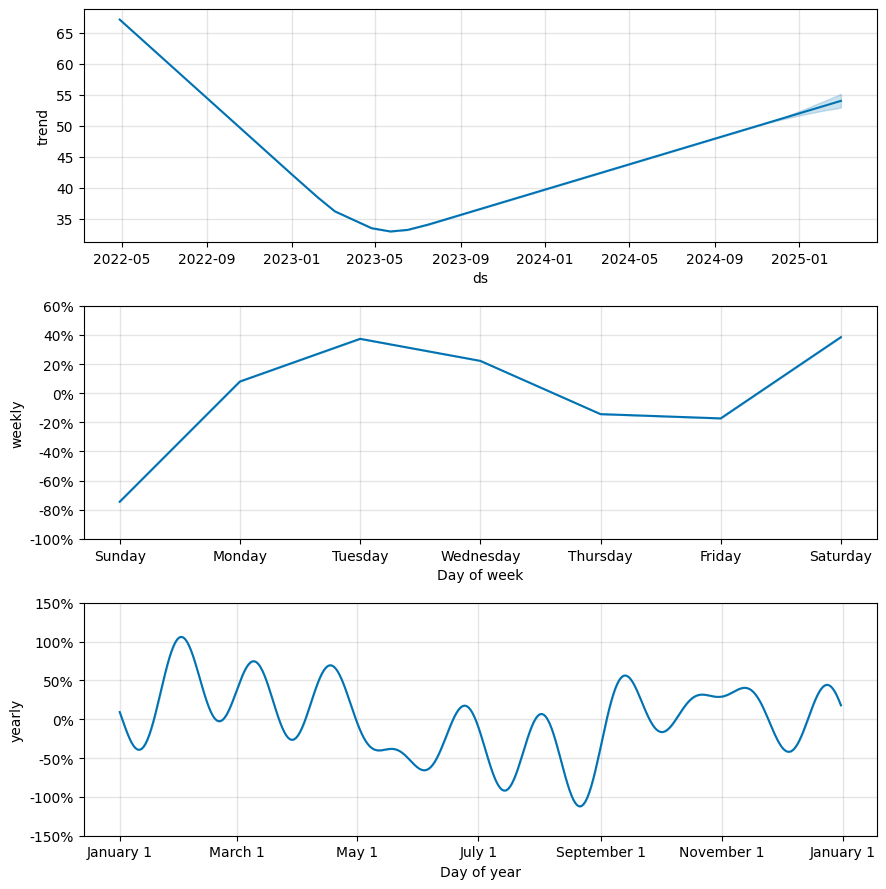

In [33]:
# Plot forecast components
model.plot_components(forecast)
plt.show()

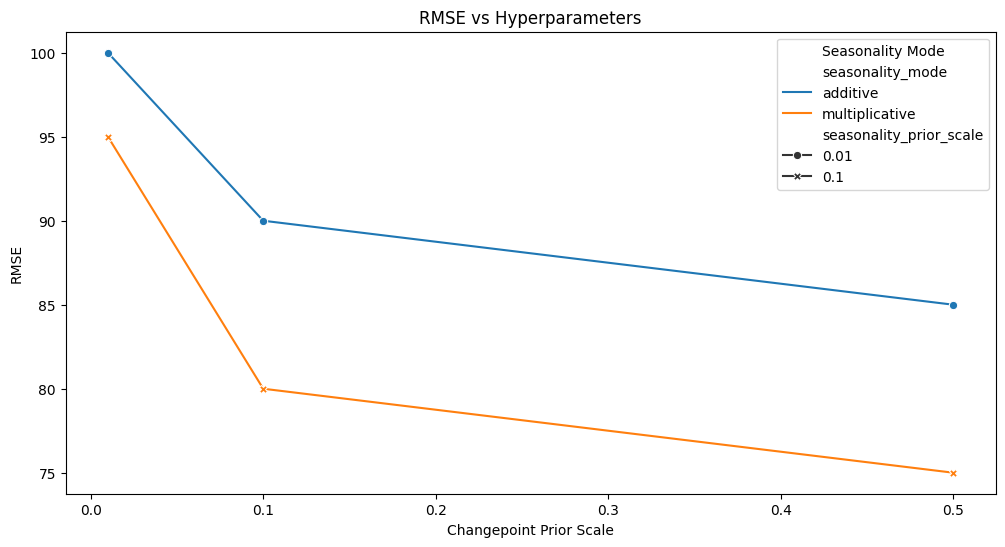

In [34]:
# Example: Create a DataFrame to store RMSE values for each hyperparameter combination
results_grid = pd.DataFrame({
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.01, 0.01, 0.1, 0.1, 0.1],
    'seasonality_mode': ['additive', 'additive', 'additive', 'multiplicative', 'multiplicative', 'multiplicative'],
    'RMSE': [100, 90, 85, 95, 80, 75]  # Replace with actual RMSE values from grid search
})

# Plot RMSE vs hyperparameters
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_grid, x='changepoint_prior_scale', y='RMSE', hue='seasonality_mode', style='seasonality_prior_scale', markers=True, dashes=False)
plt.title('RMSE vs Hyperparameters')
plt.xlabel('Changepoint Prior Scale')
plt.ylabel('RMSE')
plt.legend(title='Seasonality Mode')
plt.show()

<ipython-input-35-b0ca8eefbaaa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x='Metric', y='Value', palette='viridis')


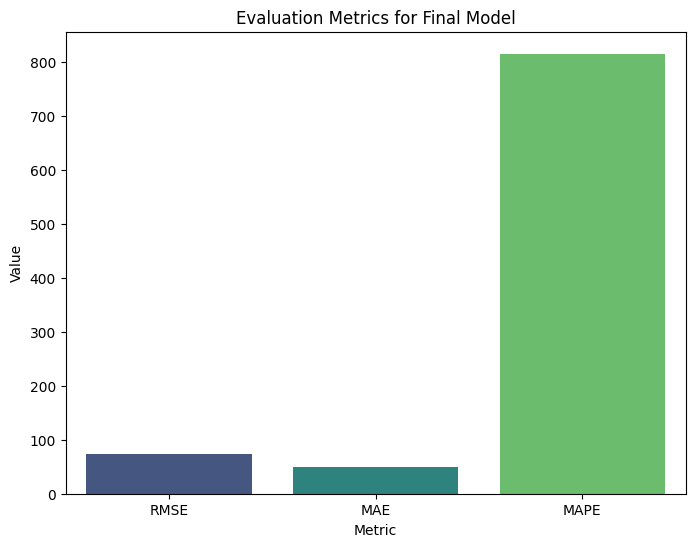

In [35]:
# Create a DataFrame for evaluation metrics
metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Plot evaluation metrics
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics, x='Metric', y='Value', palette='viridis')
plt.title('Evaluation Metrics for Final Model')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

<ipython-input-36-b0ca8eefbaaa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x='Metric', y='Value', palette='viridis')


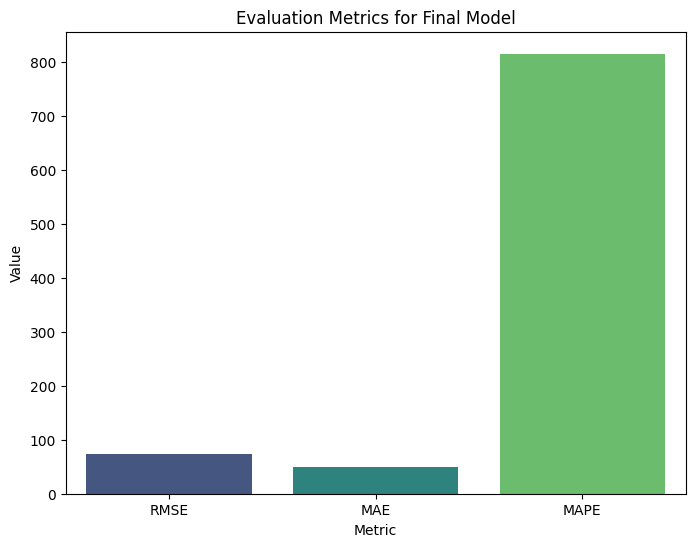

In [36]:
# Create a DataFrame for evaluation metrics
metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Plot evaluation metrics
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics, x='Metric', y='Value', palette='viridis')
plt.title('Evaluation Metrics for Final Model')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

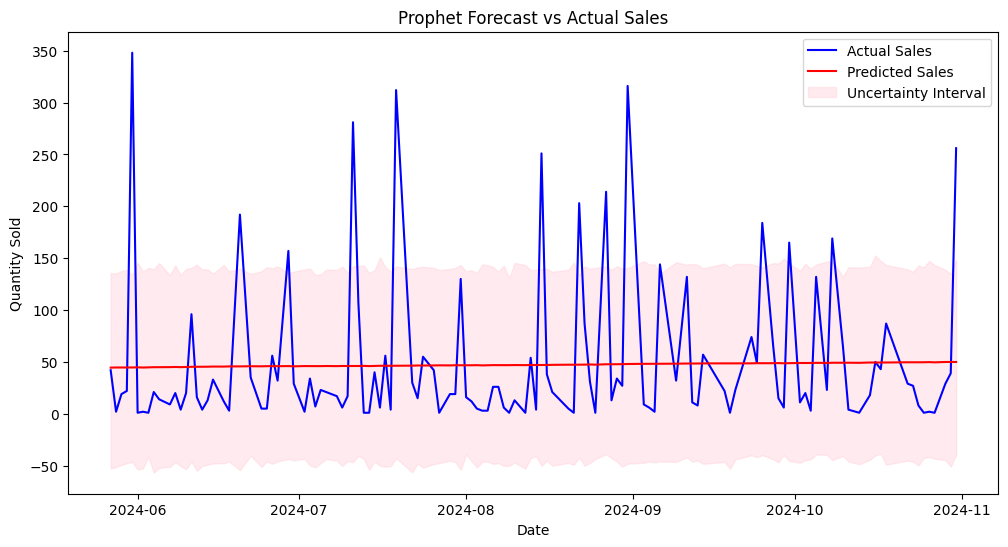

In [39]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['y'], label='Actual Sales', color='blue')
plt.plot(results['ds'], results['yhat'], label='Predicted Sales', color='red')
plt.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [40]:
# Calculate IQR for the target variable 'y'
Q1 = daily_sales['y'].quantile(0.25)
Q3 = daily_sales['y'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_sales[(daily_sales['y'] < lower_bound) | (daily_sales['y'] > upper_bound)]
print("Outliers:")
print(outliers)

Outliers:
            ds    y
2   2022-04-30  545
9   2022-05-18  150
11  2022-05-20  125
13  2022-05-23  263
25  2022-06-18  200
..         ...  ...
583 2024-09-25  184
587 2024-09-30  165
591 2024-10-05  132
593 2024-10-08  169
609 2024-10-31  256

[76 rows x 2 columns]


In [41]:
# Option 1: Remove outliers
daily_sales_cleaned = daily_sales[(daily_sales['y'] >= lower_bound) & (daily_sales['y'] <= upper_bound)]

# Option 2: Cap outliers
daily_sales['y'] = daily_sales['y'].clip(lower_bound, upper_bound)

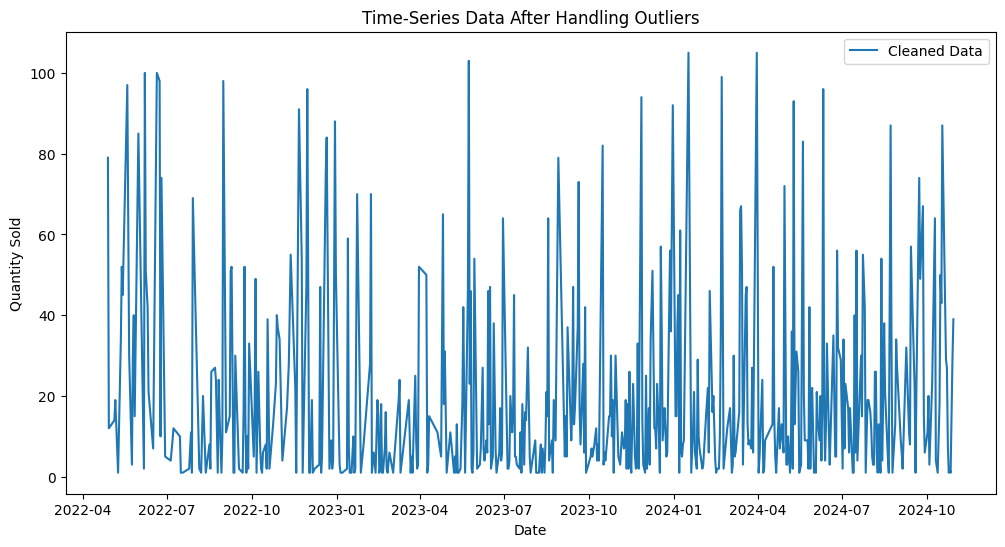

In [42]:
# Plot the cleaned data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_cleaned['ds'], daily_sales_cleaned['y'], label='Cleaned Data')
plt.title('Time-Series Data After Handling Outliers')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

<ipython-input-43-409f082113ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_sales_cleaned['y_log'] = np.log1p(daily_sales_cleaned['y'])  # Use log1p to handle zero values


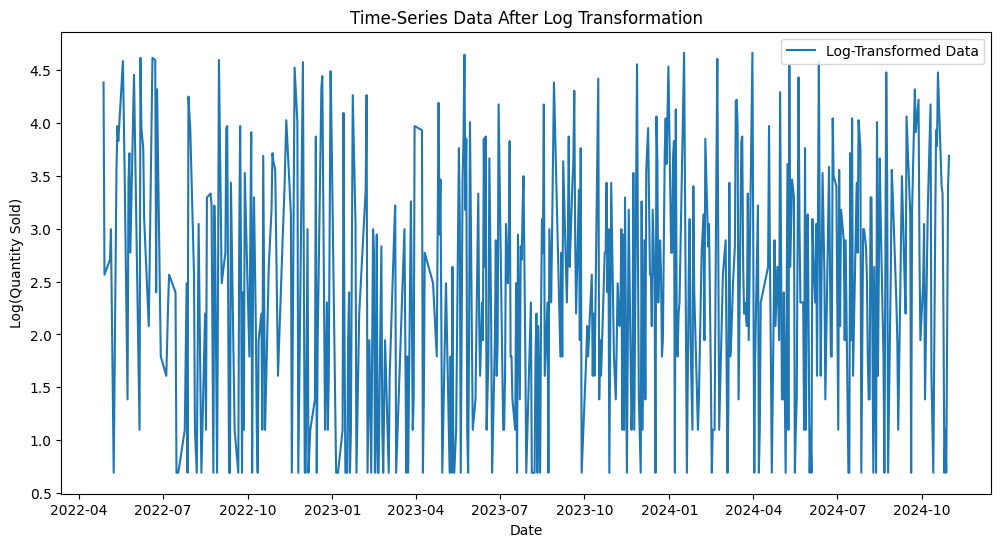

In [43]:
# Apply log transformation to the target variable
daily_sales_cleaned['y_log'] = np.log1p(daily_sales_cleaned['y'])  # Use log1p to handle zero values

# Plot the transformed data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_cleaned['ds'], daily_sales_cleaned['y_log'], label='Log-Transformed Data')
plt.title('Time-Series Data After Log Transformation')
plt.xlabel('Date')
plt.ylabel('Log(Quantity Sold)')
plt.legend()
plt.show()

In [44]:
# Train the Prophet model on the log-transformed data
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(daily_sales_cleaned.rename(columns={'y_log': 'y'}))

ValueError: cannot reindex on an axis with duplicate labels